# Exploring London Tube Neighborhood using web and Foursquare location data: Data Science Real Life

## Business Problem: Prospect of a Restaurant/Bar, close to Tube Stations in London, United Kingdom

## Introduction

London Underground, better known as the Tube, has 11 lines covering 402km and serving 270 stations. The Tube handles up to 5 million passenger journeys a day. At peak times, there are more than 543 trains whizzing around the Capital

For this project, we want to look at the neighborhood surrounding the Tube stations and classify them based on the Restaurants and Bars closest to a station. By analyzing this data, we can classify stations and explore the opportunities to start up a new business. Given this scenario, we will go through the benefits and pitfalls of opening a restaurant/bar around the neighborhood


## Target Audience

What type of clients or a group of people would be interested in this project?

1.	Business personnel who want to invest or open a restaurant/bar. This analysis will be a comprehensive guide to start or expand restaurants targeting the large pool of people availing the Tube in London
2.	Foodies and budget-conscious drinkers to find reasonable restaurants/bars on the way to home
3.	Budding Data Scientists, who want to explore more on the subject and discover new insight and solve various business problems


Import all the required Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import requests

from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

## Data Preparation

### Scraping London Underground Station data from Wikipedia

First used <a href="https://en.wikipedia.org/wiki/List_of_London_Underground_stations" target="_blank">List of London Underground stations</a> page from Wiki to scrap the table to create a dataframe

In [2]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_London_Underground_stations')
df1 = wiki[0]
header = df1.iloc[0]
df1 = df1[1:]
df1.columns = header
df1.head()

0       Station Photograph                     Line(s)[*] Local authority  \
1    Acton Town        NaN             DistrictPiccadilly          Ealing   
2       Aldgate        NaN          Metropolitan[a]Circle  City of London   
3  Aldgate East        NaN  Hammersmith & City[d]District   Tower Hamlets   
4      Alperton        NaN                  Piccadilly[h]           Brent   
5      Amersham        NaN                   Metropolitan        Chiltern   

0 Zone(s)[†]                              Opened[4] Main lineopened  \
1          3                            1 July 1879             NaN   
2          1                       18 November 1876             NaN   
3          1  6 October 1884resited 31 October 1938             NaN   
4          4                           28 June 1903             NaN   
5          9                       1 September 1892             NaN   

0                              Other name(s)[note 2] Usage[5]  
1                          Mill Hill Park: 1879–1910     5.99  
2                                                NaN     8.47  
3           Commercial Road: Proposed before opening    13.17  
4                         Perivale-Alperton: 1903–10     2.82  
5  Amersham: 1892–1922Amersham & Chesham Bois: 19...     2.10

After little manipulation of the data, the dataframe is obtained as below

In [3]:
df1 = df1.rename(columns={'Line(s)[*]': 'Lines','Zone(s)[†]':'Zones'})
df1 = df1.iloc[:,[0,2,3,4]]
df1 = df1.replace('(\[[a-z]\])', '',regex = True)
df1.head()

0       Station                       Lines Local authority Zones
1    Acton Town          DistrictPiccadilly          Ealing     3
2       Aldgate          MetropolitanCircle  City of London     1
3  Aldgate East  Hammersmith & CityDistrict   Tower Hamlets     1
4      Alperton                  Piccadilly           Brent     4
5      Amersham                Metropolitan        Chiltern     9

Next used <a href="https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations" target="_blank">Geo details of London Underground stations</a> to get the Coordinates and created the below dataframe from the table


In [4]:
wiki = pd.read_html('https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations')
df2 = wiki[0]
df2 = df2.iloc[:,[0,1,2,6]]
header = df2.iloc[0]
df2 = df2[1:]
df2.columns = header
df2.head()

0           Name     Latitude     Longitude                          Line
1     Acton Town    51.502500     -0.278126          District, Piccadilly
2  Acton Central  51.50883531  -0.263033174             London Overground
3  Acton Central  51.50856013  -0.262879534             London Overground
4        Aldgate     51.51394      -0.07537                  Metropolitan
5   Aldgate East     51.51514      -0.07178  District, Hammersmith & City

Joined the above 2 dataframes to obtain the dataframe as below

In [5]:
london_tube_geo = df1.merge(df2, how='inner', left_on='Station', right_on='Name')
london_tube_geo.head()

0       Station                       Lines Local authority Zones  \
0    Acton Town          DistrictPiccadilly          Ealing     3   
1       Aldgate          MetropolitanCircle  City of London     1   
2  Aldgate East  Hammersmith & CityDistrict   Tower Hamlets     1   
3      Alperton                  Piccadilly           Brent     4   
4      Amersham                Metropolitan        Chiltern     9   

0          Name   Latitude  Longitude                          Line  
0    Acton Town  51.502500  -0.278126          District, Piccadilly  
1       Aldgate   51.51394   -0.07537                  Metropolitan  
2  Aldgate East   51.51514   -0.07178  District, Hammersmith & City  
3      Alperton   51.54097   -0.30061                    Piccadilly  
4      Amersham   51.67435   -0.60732                  Metropolitan

Dropped the common columns to obtain the final dataframe for analysis

In [6]:
london_tube_geo = london_tube_geo.drop(columns = ['Name','Line'])
london_tube_geo.head()

0       Station                       Lines Local authority Zones   Latitude  \
0    Acton Town          DistrictPiccadilly          Ealing     3  51.502500   
1       Aldgate          MetropolitanCircle  City of London     1   51.51394   
2  Aldgate East  Hammersmith & CityDistrict   Tower Hamlets     1   51.51514   
3      Alperton                  Piccadilly           Brent     4   51.54097   
4      Amersham                Metropolitan        Chiltern     9   51.67435   

0  Longitude  
0  -0.278126  
1   -0.07537  
2   -0.07178  
3   -0.30061  
4   -0.60732

### Removed duplicate records and repalced coordinates with correct values 

After little more playing around with pandas, could get one well-arranged dataframe as below

In [7]:
london_tube_geo.at[36,'Latitude']= '51.49787'
london_tube_geo.at[36,'Longitude']= '-0.04967'

london_tube_geo['Latitude'] = london_tube_geo['Latitude'].astype(float)
london_tube_geo['Longitude'] = london_tube_geo['Longitude'].astype(float)

london_tube_geo = london_tube_geo.drop_duplicates(subset=['Station', 'Local authority', 'Zones'])
london_tube_geo.reset_index(drop = True)
london_tube_geo[london_tube_geo.duplicated(['Station'], keep=False)]


london_tube_geo['Latitude'] = london_tube_geo['Latitude'].astype(str)
london_tube_geo['Longitude'] = london_tube_geo['Longitude'].astype(str)
london_tube_geo.head()

0       Station                       Lines Local authority Zones  Latitude  \
0    Acton Town          DistrictPiccadilly          Ealing     3   51.5025   
1       Aldgate          MetropolitanCircle  City of London     1  51.51394   
2  Aldgate East  Hammersmith & CityDistrict   Tower Hamlets     1  51.51514   
3      Alperton                  Piccadilly           Brent     4  51.54097   
4      Amersham                Metropolitan        Chiltern     9  51.67435   

0  Longitude  
0  -0.278126  
1   -0.07537  
2   -0.07178  
3   -0.30061  
4   -0.60732

## Using Foursquare Location Data

Foursquare outlines high-level venue categories with sub-categories. Used Foursquare API to explore food venues surrounding each station using **<font color=blue>Food sub-category id (4d4b7105d754a06374d81259)</font>**. Queried 100 popular spots in a 1000m radius around each station. This radius was chosen because 1000m is a reasonable walking distance within each station. Below is a function which returns all the Food venues by category for the neighborhoods passed. The call returns a JSON file which needs to be converted into a dataframe

In [8]:
CLIENT_ID = 'RWTHDY1ZNUATGDAURL34GGT4B5EGXSSCDPNX1SGPWDFKJTMY' # Foursquare ID
CLIENT_SECRET = '40D1XMRR34YV4ZCJZJ0QMAEP3GWRUUJYMQGJ3IRXK41USFMY' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

limit = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

def getNearbyVenues(names, latitudes, longitudes):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)

**<font color=blue>getNearbyVenues</font>** function as defined above is called to get top 100 Food venues around 1000m radius of all the Tube stations. Below is the dataframe obtained from the JSON file that was returned by Foursquare. We have obtained this data for each Station 

In [9]:
london_tube_food_venue = getNearbyVenues(names=london_tube_geo['Station'],
                                   latitudes=london_tube_geo['Latitude'],
                                   longitudes=london_tube_geo['Longitude']
                                  )

london_tube_food_venue.head()

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
0   Acton Town               51.5025              -0.278126   
1   Acton Town               51.5025              -0.278126   
2   Acton Town               51.5025              -0.278126   
3   Acton Town               51.5025              -0.278126   
4   Acton Town               51.5025              -0.278126   

                           Venue  Venue Latitude  Venue Longitude  \
0           The Apple Tree Cakes       51.503174        -0.280474   
1                WP Fish X Chips       51.502580        -0.281240   
2  London Transport Museum Depot       51.504175        -0.280622   
3        Gunnersbury Park Museum       51.499661        -0.286223   
4                   Acton Centre       51.506608        -0.266878   

         Venue Category  
0           Coffee Shop  
1     Fish & Chips Shop  
2                Museum  
3                Museum  
4  Gym / Fitness Center

Combining Zones with the returned reseltset for future data exploration and insight

In [10]:
london_tube_food_venue_by_zone = london_tube_food_venue.merge(london_tube_geo, how='inner', left_on='Neighborhood', right_on='Station')
london_tube_food_venue_by_zone = london_tube_food_venue_by_zone.drop(columns = ['Station','Lines','Local authority','Latitude','Longitude'])
london_tube_food_venue_by_zone.reset_index(drop = True)
london_tube_food_venue_by_zone.head()

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
0   Acton Town               51.5025              -0.278126   
1   Acton Town               51.5025              -0.278126   
2   Acton Town               51.5025              -0.278126   
3   Acton Town               51.5025              -0.278126   
4   Acton Town               51.5025              -0.278126   

                           Venue  Venue Latitude  Venue Longitude  \
0           The Apple Tree Cakes       51.503174        -0.280474   
1                WP Fish X Chips       51.502580        -0.281240   
2  London Transport Museum Depot       51.504175        -0.280622   
3        Gunnersbury Park Museum       51.499661        -0.286223   
4                   Acton Centre       51.506608        -0.266878   

         Venue Category Zones  
0           Coffee Shop     3  
1     Fish & Chips Shop     3  
2                Museum     3  
3                Museum     3  
4  Gym / Fitness Center     3

## Data Exploration and Visualization

Since I am interested in Restaurants & Bars as popular spots, first created a dataframe where the **<font color=blue>Venue Category</font>**  column in previous dataframe contains the word **<font color=blue>Restaurant</font>**

In [11]:
london_tube_only_restaurants = london_tube_food_venue_by_zone[london_tube_food_venue_by_zone['Venue Category'].str.contains('Restaurant')]
london_tube_only_restaurants.reset_index(drop = True)
london_tube_only_restaurants.head()

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
13   Acton Town               51.5025              -0.278126   
16   Acton Town               51.5025              -0.278126   
18   Acton Town               51.5025              -0.278126   
28   Acton Town               51.5025              -0.278126   
29   Acton Town               51.5025              -0.278126   

                     Venue  Venue Latitude  Venue Longitude  \
13              casereccio       51.502436        -0.281674   
16      The Corner Terrace       51.509839        -0.286459   
18       Amigo's Peri Peri       51.508396        -0.274561   
28          Persian Nights       51.508529        -0.282383   
29  North China Restaurant       51.508251        -0.277435   

                 Venue Category Zones  
13           Italian Restaurant     3  
16  Eastern European Restaurant     3  
18         Fast Food Restaurant     3  
28    Middle Eastern Restaurant     3  
29           Chinese Restaurant     3

Next created a dataframe where the **<font color=blue>Venue Category</font>**  column in previous dataframe contains the word **<font color=blue>Bar</font>**

In [12]:
london_tube_only_bars = london_tube_food_venue_by_zone[london_tube_food_venue_by_zone['Venue Category'].str.contains('Bar')]
london_tube_only_bars.reset_index(drop = True)
london_tube_only_bars.head()

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
35    Acton Town               51.5025              -0.278126   
53       Aldgate              51.51394               -0.07537   
96       Aldgate              51.51394               -0.07537   
98       Aldgate              51.51394               -0.07537   
105      Aldgate              51.51394               -0.07537   

                         Venue  Venue Latitude  Venue Longitude  \
35              The Chatsworth       51.508373        -0.276460   
53       Discount Suit Company       51.516705        -0.075506   
96                Kill The Cat       51.518658        -0.071516   
98                     BrewDog       51.509948        -0.080977   
105  citizenM 7th Floor Skybar       51.510049        -0.076615   

    Venue Category Zones  
35    Cocktail Bar     3  
53    Cocktail Bar     1  
96        Beer Bar     1  
98        Beer Bar     1  
105      Hotel Bar     1

Used One-hot encoding feature for effective prediction of the **<font color=blue>Restaurants</font>**
- Created a dataframe with pandas one hot encoding for the Venue Categories
- Used pandas groupby on the Neighborhood column and obtained one-hot encoded Venue Categories
- Transposed the dataframe at step 2 and arranged in descending order

In [13]:
# one hot encoding
lt_onehot = pd.get_dummies(london_tube_only_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lt_onehot['Neighborhood'] = london_tube_only_restaurants['Neighborhood'] 

# move neighborhood column to the first column
Neighborhood = lt_onehot['Neighborhood']

lt_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
lt_onehot.insert(0, 'Neighborhood', Neighborhood)

restaurant_counts = lt_onehot.groupby('Neighborhood').sum()

restaurant_counts_described = restaurant_counts.describe().transpose()
restaurant_top10 = restaurant_counts_described.sort_values('max', ascending=False)[0:10]
restaurant_top10

count      mean       std  min  25%  50%  75%  max
Indian Restaurant      245.0  1.326531  1.530935  0.0  0.0  1.0  2.0  8.0
Italian Restaurant     245.0  1.869388  1.913948  0.0  0.0  1.0  3.0  8.0
Portuguese Restaurant  245.0  0.391837  0.713981  0.0  0.0  0.0  1.0  7.0
French Restaurant      245.0  0.738776  1.073682  0.0  0.0  0.0  1.0  6.0
Restaurant             245.0  1.008163  1.247922  0.0  0.0  1.0  2.0  6.0
Japanese Restaurant    245.0  0.604082  0.911214  0.0  0.0  0.0  1.0  6.0
Persian Restaurant     245.0  0.232653  0.712128  0.0  0.0  0.0  0.0  5.0
Fast Food Restaurant   245.0  0.636735  0.984864  0.0  0.0  0.0  1.0  5.0
Sushi Restaurant       245.0  0.375510  0.711305  0.0  0.0  0.0  1.0  5.0
Turkish Restaurant     245.0  0.408163  0.781926  0.0  0.0  0.0  1.0  5.0

Top 10 list of unique **<font color=blue>Restaurants</font>** around the Tube stations

In [14]:
restaurant_top10_list = restaurant_top10.index.values.tolist()
restaurant_top10_list

['Indian Restaurant',
 'Italian Restaurant',
 'Portuguese Restaurant',
 'French Restaurant',
 'Restaurant',
 'Japanese Restaurant',
 'Persian Restaurant',
 'Fast Food Restaurant',
 'Sushi Restaurant',
 'Turkish Restaurant']

Plotted a Bar chart with the number of Top 10 **<font color=blue>Restaurants</font>** by Station

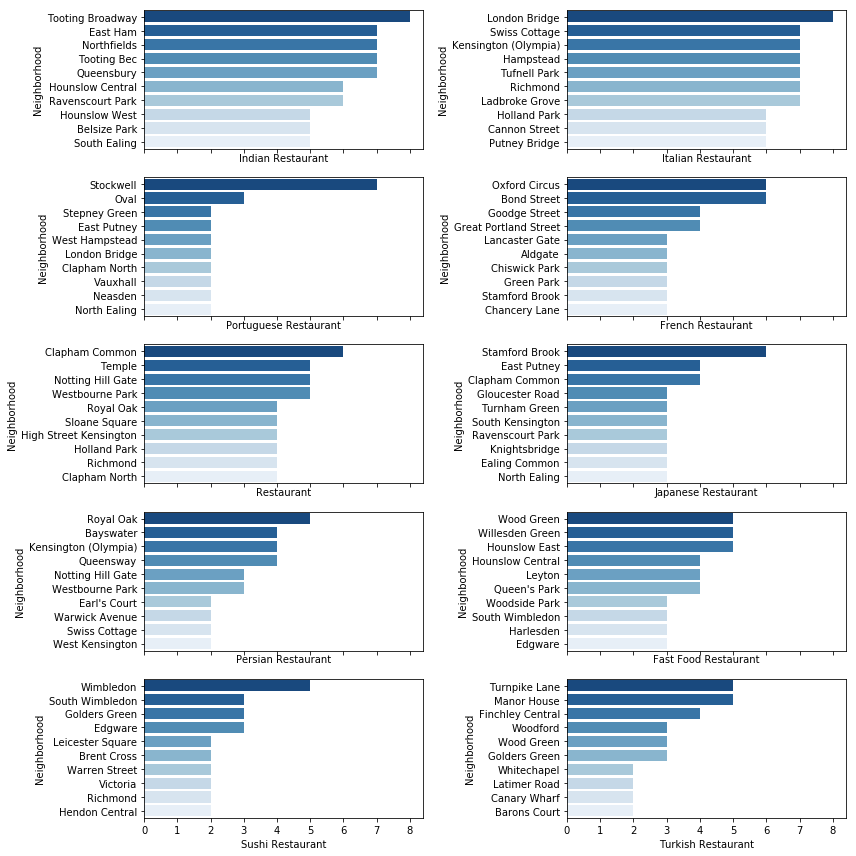

In [15]:
fig, axes =plt.subplots(5, 2, figsize=(12,12), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, restaurant_top10_list):
    data = restaurant_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

Used One-hot encoding feature for effective prediction of the **<font color=blue>Bars</font>**
- Created a dataframe with pandas one hot encoding for the Venue Categories
- Used pandas groupby on the Neighborhood column and obtained one-hot encoded Venue Categories
- Transposed the dataframe at step 2 and arranged in descending order

In [16]:
# one hot encoding
lt_onehot = pd.get_dummies(london_tube_only_bars[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
lt_onehot['Neighborhood'] = london_tube_only_bars['Neighborhood'] 

# move neighborhood column to the first column
Neighborhood = lt_onehot['Neighborhood']

lt_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
lt_onehot.insert(0, 'Neighborhood', Neighborhood)

bar_counts = lt_onehot.groupby('Neighborhood').sum()

bar_counts_described = bar_counts.describe().transpose()
bar_top10 = bar_counts_described.sort_values('max', ascending=False)[0:10]
bar_top10

count      mean       std  min  25%  50%  75%  max
Cocktail Bar  170.0  1.094118  1.476631  0.0  0.0  0.5  2.0  6.0
Bar           170.0  1.076471  1.098697  0.0  0.0  1.0  2.0  5.0
Hotel Bar     170.0  0.347059  0.837450  0.0  0.0  0.0  0.0  5.0
Beer Bar      170.0  0.541176  0.822076  0.0  0.0  0.0  1.0  4.0
Gay Bar       170.0  0.129412  0.539301  0.0  0.0  0.0  0.0  4.0
Juice Bar     170.0  0.400000  0.831339  0.0  0.0  0.0  0.0  4.0
Wine Bar      170.0  0.711765  0.919469  0.0  0.0  0.0  1.0  4.0
Hookah Bar    170.0  0.135294  0.375966  0.0  0.0  0.0  0.0  2.0
Sports Bar    170.0  0.088235  0.304566  0.0  0.0  0.0  0.0  2.0
Whisky Bar    170.0  0.047059  0.238629  0.0  0.0  0.0  0.0  2.0

Top 10 list of unique **<font color=blue>Bars</font>** around the Tube stations

In [17]:
bar_top10_list = bar_top10.index.values.tolist()
bar_top10_list

['Cocktail Bar',
 'Bar',
 'Hotel Bar',
 'Beer Bar',
 'Gay Bar',
 'Juice Bar',
 'Wine Bar',
 'Hookah Bar',
 'Sports Bar',
 'Whisky Bar']

Plotted a Bar chart with the number of Top 10 **<font color=blue>Bars</font>** by Station

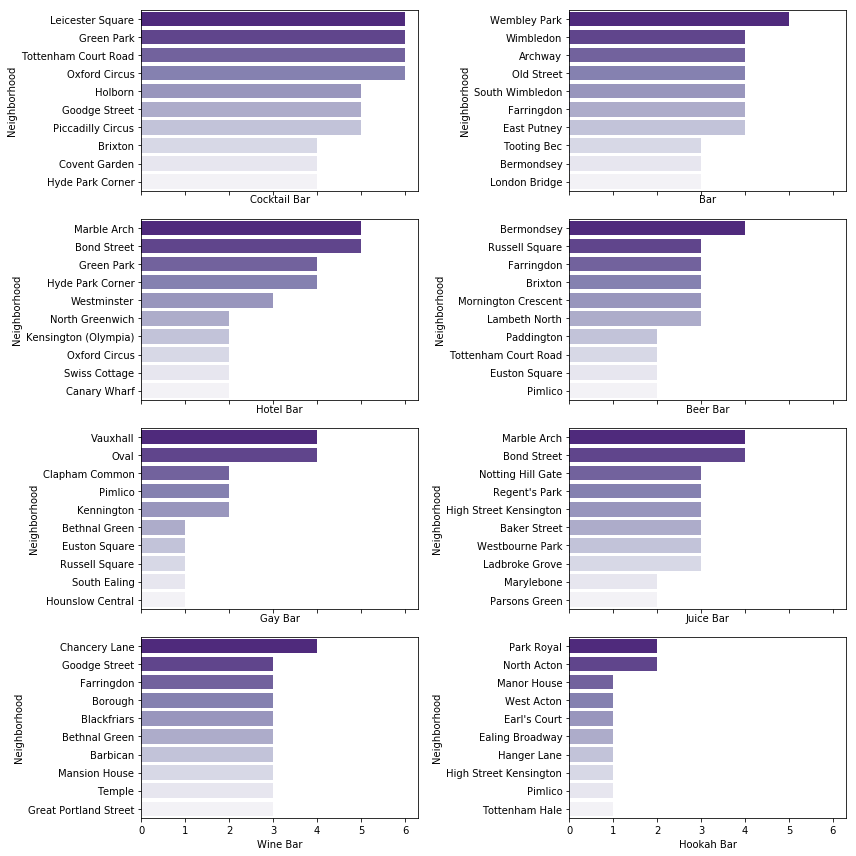

In [18]:
fig, axes =plt.subplots(4, 2, figsize=(12,12), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, bar_top10_list):
    data = bar_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Purples", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

Created a dataframe with Restaurant & Bar Count by Station(Neighborhood) for further analysis

In [19]:
rest_count = london_tube_food_venue_by_zone[london_tube_food_venue_by_zone['Venue Category'].str.contains('Restaurant')].groupby('Neighborhood', as_index=False)['Neighborhood'].agg({'Restaurant Count':'count'})
bar_count = london_tube_food_venue_by_zone[london_tube_food_venue_by_zone['Venue Category'].str.contains('Bar')].groupby('Neighborhood', as_index=False)['Neighborhood'].agg({'Bar Count':'count'})

rest_bar_count = rest_count.merge(bar_count, how='left', left_on='Neighborhood', right_on='Neighborhood')
rest_bar_count['Bar Count'] = rest_bar_count['Bar Count'].fillna(0).astype(np.int64)
rest_bar_count = rest_bar_count.sort_values("Neighborhood", ascending=False)
rest_bar_count.head()

Neighborhood  Restaurant Count  Bar Count
244   Woodside Park                11          1
243        Woodford                 9          0
242      Wood Green                21          3
241  Wimbledon Park                 5          2
240       Wimbledon                30          7

Plotted a Stacked Bar chart for **<font color=blue>Restaurants & Bars</font>** by Station **and observed that Restaurants are more abundant within 1000m radius of the Tube Stations. Some Stations are even missing Bars within 1000m of thier radius**

Text(0.5,1,'Restaurant & Bars by Neigborhood')

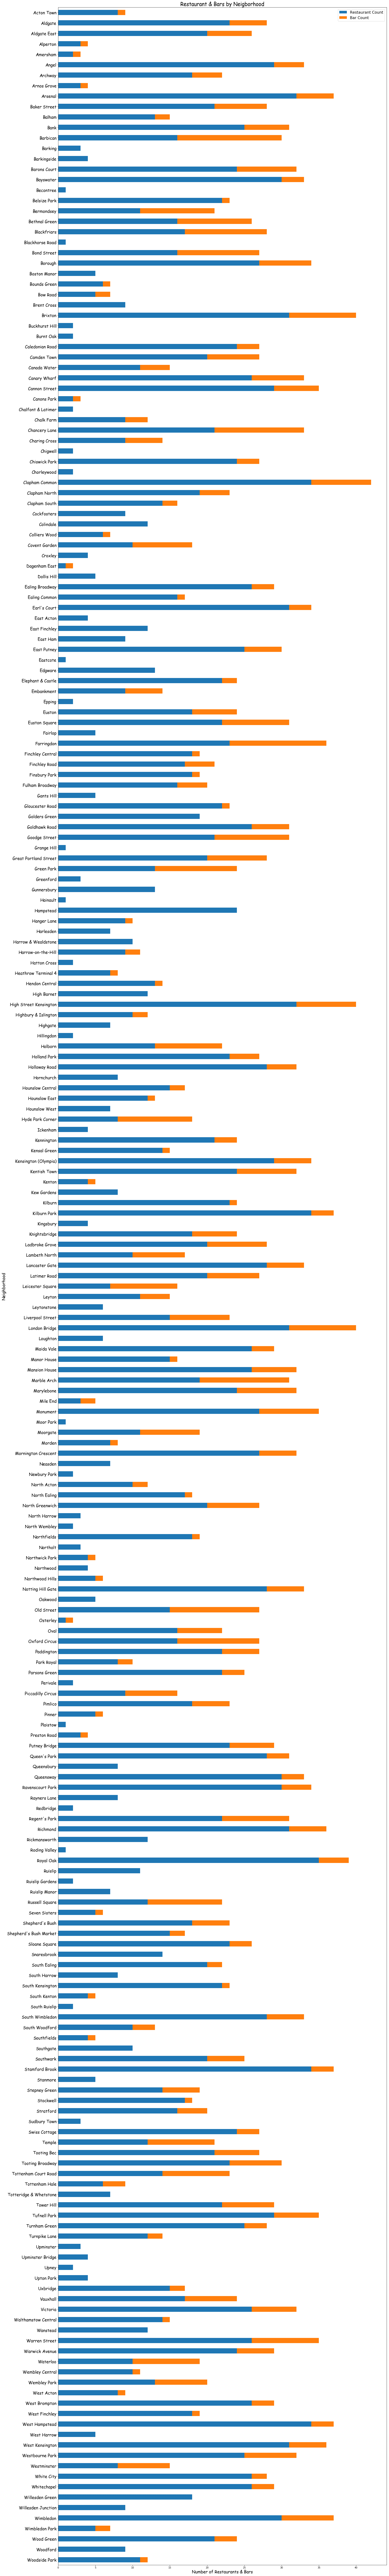

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(25,200)

rest_bar_count.plot.barh(stacked=True, ax=ax);

ax.legend(loc='upper right',fontsize=16)
ax.set_yticklabels(rest_bar_count['Neighborhood'], fontname="Comic Sans MS", fontsize=18)
ax.set_xlabel('Number of Restaurants & Bars', fontname="Comic Sans MS", fontsize=18)
ax.set_ylabel("Neighborhood", fontname="Comic Sans MS", fontsize=18)
ax.set_title("Restaurant & Bars by Neigborhood", fontname='Comic Sans MS', fontsize=22)


Created a dataframe with **<font color=blue>ONLY Restaurants & Bars</font>** around Tube Stations for final analysis

In [22]:
search_values = ['Restaurant','Bar']
london_tube_rest_bar = london_tube_food_venue_by_zone[london_tube_food_venue_by_zone['Venue Category'].str.contains('|'.join(search_values ))]
london_tube_rest_bar.head()

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
13   Acton Town               51.5025              -0.278126   
16   Acton Town               51.5025              -0.278126   
18   Acton Town               51.5025              -0.278126   
28   Acton Town               51.5025              -0.278126   
29   Acton Town               51.5025              -0.278126   

                     Venue  Venue Latitude  Venue Longitude  \
13              casereccio       51.502436        -0.281674   
16      The Corner Terrace       51.509839        -0.286459   
18       Amigo's Peri Peri       51.508396        -0.274561   
28          Persian Nights       51.508529        -0.282383   
29  North China Restaurant       51.508251        -0.277435   

                 Venue Category Zones  
13           Italian Restaurant     3  
16  Eastern European Restaurant     3  
18         Fast Food Restaurant     3  
28    Middle Eastern Restaurant     3  
29           Chinese Restaurant     3

## Clustering the Stations

Used One-hot encoding feature for effective prediction
- Created a dataframe with pandas one hot encoding for the Venue Categories
- Used pandas groupby on the Neighborhood column and obtained nd obtain the mean of the one-hot encoded Venue Categories
- Transposed the dataframe at step 2 and arranged in descending order

In [23]:
# one hot encoding
london_food_onehot = pd.get_dummies(london_tube_rest_bar[['Venue Category']], prefix="", prefix_sep="")

london_food_onehot['Neighborhoods'] = london_tube_rest_bar['Neighborhood'] 
london_food_onehot.head()

# move neighborhood column to the first column
fixed_columns = [london_food_onehot.columns[-1]] + list(london_food_onehot.columns[:-3])
london_food_onehot = london_food_onehot[fixed_columns]

london_food_grouped = london_food_onehot.groupby('Neighborhoods').mean().reset_index()
london_food_grouped.head()

Neighborhoods  Afghan Restaurant  African Restaurant  American Restaurant  \
0    Acton Town                0.0                 0.0                  0.0   
1       Aldgate                0.0                 0.0                  0.0   
2  Aldgate East                0.0                 0.0                  0.0   
3      Alperton                0.0                 0.0                  0.0   
4      Amersham                0.0                 0.0                  0.0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0               0.0                     0.0          0.000000   
1               0.0                     0.0          0.035714   
2               0.0                     0.0          0.038462   
3               0.0                     0.0          0.250000   
4               0.0                     0.0          0.000000   

   Australian Restaurant  Austrian Restaurant       Bar  \
0                    0.0                  0.0  0.000000   
1                    0.0                  0.0  0.000000   
2                    0.0                  0.0  0.038462   
3                    0.0                  0.0  0.000000   
4                    0.0                  0.0  0.333333   

           ...            Sushi Restaurant  Szechuan Restaurant  \
0          ...                         0.0                  0.0   
1          ...                         0.0                  0.0   
2          ...                         0.0                  0.0   
3          ...                         0.0                  0.0   
4          ...                         0.0                  0.0   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  Turkish Restaurant  \
0          0.000000         0.000000               0.0            0.000000   
1          0.035714         0.000000               0.0            0.035714   
2          0.000000         0.000000               0.0            0.038462   
3          0.000000         0.000000               0.0            0.000000   
4          0.000000         0.333333               0.0            0.333333   

   Ukrainian Restaurant  Vegetarian / Vegan Restaurant  Veneto Restaurant  \
0                   0.0                       0.000000                0.0   
1                   0.0                       0.035714                0.0   
2                   0.0                       0.038462                0.0   
3                   0.0                       0.000000                0.0   
4                   0.0                       0.000000                0.0   

   Vietnamese Restaurant  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  

[5 rows x 96 columns]

**<font color=blue>returnMostcommonVenues</font>** function returns Top 10 venues and sorts them in descending order

In [24]:
def returnMostcommonVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Created the new dataframe and display the top 10 Restaurants & Bars for each Station(Neighborhood)

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = london_food_grouped['Neighborhoods']

for ind in np.arange(london_food_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = returnMostcommonVenues(london_food_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhoods 1st Most Common Venue      2nd Most Common Venue  \
0    Acton Town   Japanese Restaurant  Middle Eastern Restaurant   
1       Aldgate     French Restaurant                 Restaurant   
2  Aldgate East          Cocktail Bar  Middle Eastern Restaurant   
3      Alperton      Asian Restaurant          Indian Restaurant   
4      Amersham    Turkish Restaurant            Thai Restaurant   

  3rd Most Common Venue      4th Most Common Venue  5th Most Common Venue  \
0  Fast Food Restaurant               Cocktail Bar     Chinese Restaurant   
1              Beer Bar  Middle Eastern Restaurant    Japanese Restaurant   
2            Restaurant          French Restaurant    Japanese Restaurant   
3  Fast Food Restaurant                 Hookah Bar  Vietnamese Restaurant   
4                   Bar      Vietnamese Restaurant       Greek Restaurant   

         6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Eastern European Restaurant    Italian Restaurant      Kebab Restaurant   
1            Korean Restaurant     Indian Restaurant    Falafel Restaurant   
2            Korean Restaurant              Beer Bar  Colombian Restaurant   
3            German Restaurant   Empanada Restaurant    English Restaurant   
4          Empanada Restaurant    English Restaurant  Ethiopian Restaurant   

      9th Most Common Venue 10th Most Common Venue  
0     Indonesian Restaurant      Indian Restaurant  
1      Colombian Restaurant           Cocktail Bar  
2  Mediterranean Restaurant                    Bar  
3      Ethiopian Restaurant     Falafel Restaurant  
4        Falafel Restaurant   Fast Food Restaurant

### Clustering the Station(Neighborhood) using K-Means

Run k-means to cluster the Station(Neighborhood) into 5 clusters

In [26]:
# set number of clusters
kclusters = 5

london_food_grouped_clustering = london_food_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_food_grouped_clustering)

Created a new dataframe that includes the cluster as well as the top 10 venues for each Station(Neighborhood)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


london_merged = london_tube_rest_bar

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

london_merged.head() # check the last columns!

Neighborhood Neighborhood Latitude Neighborhood Longitude  \
13   Acton Town               51.5025              -0.278126   
16   Acton Town               51.5025              -0.278126   
18   Acton Town               51.5025              -0.278126   
28   Acton Town               51.5025              -0.278126   
29   Acton Town               51.5025              -0.278126   

                     Venue  Venue Latitude  Venue Longitude  \
13              casereccio       51.502436        -0.281674   
16      The Corner Terrace       51.509839        -0.286459   
18       Amigo's Peri Peri       51.508396        -0.274561   
28          Persian Nights       51.508529        -0.282383   
29  North China Restaurant       51.508251        -0.277435   

                 Venue Category Zones  Cluster Labels 1st Most Common Venue  \
13           Italian Restaurant     3               2   Japanese Restaurant   
16  Eastern European Restaurant     3               2   Japanese Restaurant   
18         Fast Food Restaurant     3               2   Japanese Restaurant   
28    Middle Eastern Restaurant     3               2   Japanese Restaurant   
29           Chinese Restaurant     3               2   Japanese Restaurant   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
13  Middle Eastern Restaurant  Fast Food Restaurant          Cocktail Bar   
16  Middle Eastern Restaurant  Fast Food Restaurant          Cocktail Bar   
18  Middle Eastern Restaurant  Fast Food Restaurant          Cocktail Bar   
28  Middle Eastern Restaurant  Fast Food Restaurant          Cocktail Bar   
29  Middle Eastern Restaurant  Fast Food Restaurant          Cocktail Bar   

   5th Most Common Venue        6th Most Common Venue 7th Most Common Venue  \
13    Chinese Restaurant  Eastern European Restaurant    Italian Restaurant   
16    Chinese Restaurant  Eastern European Restaurant    Italian Restaurant   
18    Chinese Restaurant  Eastern European Restaurant    Italian Restaurant   
28    Chinese Restaurant  Eastern European Restaurant    Italian Restaurant   
29    Chinese Restaurant  Eastern European Restaurant    Italian Restaurant   

   8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
13      Kebab Restaurant  Indonesian Restaurant      Indian Restaurant  
16      Kebab Restaurant  Indonesian Restaurant      Indian Restaurant  
18      Kebab Restaurant  Indonesian Restaurant      Indian Restaurant  
28      Kebab Restaurant  Indonesian Restaurant      Indian Restaurant  
29      Kebab Restaurant  Indonesian Restaurant      Indian Restaurant

### Visualizing the 7 clusters in a London map using Folium library

In [28]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles="Stamen Toner", zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Neighborhood Latitude'], london_merged['Neighborhood Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster

### Cluster 0

In [30]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  Zones  \
1207               51.54029         0.113216    Chinese Restaurant      5   
6261               51.55364        -0.449054    Chinese Restaurant      6   
6264               51.55364        -0.448794  Fast Food Restaurant      6   
6813               51.56147        -0.445925    Chinese Restaurant      6   
6814               51.56147        -0.446161     Indian Restaurant      6   
6817               51.56147        -0.439185     Indian Restaurant      6   
6818               51.56147        -0.439186    Chinese Restaurant      6   
9117            51.62970512        -0.434700    Chinese Restaurant  6 & 7   
13774              51.53824         0.092085    Chinese Restaurant      4   
13776              51.53824         0.113216    Chinese Restaurant      4   

       Cluster Labels 1st Most Common Venue  2nd Most Common Venue  \
1207                0    Chinese Restaurant  Vietnamese Restaurant   
6261                0  Fast Food Restaurant     Chinese Restaurant   
6264                0  Fast Food Restaurant     Chinese Restaurant   
6813                0     Indian Restaurant     Chinese Restaurant   
6814                0     Indian Restaurant     Chinese Restaurant   
6817                0     Indian Restaurant     Chinese Restaurant   
6818                0     Indian Restaurant     Chinese Restaurant   
9117                0    Chinese Restaurant  Vietnamese Restaurant   
13774               0    Chinese Restaurant  Vietnamese Restaurant   
13776               0    Chinese Restaurant  Vietnamese Restaurant   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1207     Dumpling Restaurant   Empanada Restaurant    English Restaurant   
6261   Vietnamese Restaurant   Dumpling Restaurant   Empanada Restaurant   
6264   Vietnamese Restaurant   Dumpling Restaurant   Empanada Restaurant   
6813   Vietnamese Restaurant     German Restaurant   Empanada Restaurant   
6814   Vietnamese Restaurant     German Restaurant   Empanada Restaurant   
6817   Vietnamese Restaurant     German Restaurant   Empanada Restaurant   
6818   Vietnamese Restaurant     German Restaurant   Empanada Restaurant   
9117     Dumpling Restaurant   Empanada Restaurant    English Restaurant   
13774    Dumpling Restaurant   Empanada Restaurant    English Restaurant   
13776    Dumpling Restaurant   Empanada Restaurant    English Restaurant   

      6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1207   Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
6261     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
6264     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
6813     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
6814     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
6817     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
6818     English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
9117   Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
13774  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
13776  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   

      9th Most Common Venue 10th Most Common Venue  
1207    Filipino Restaurant      French Restaurant  
6261    Filipino Restaurant      French Restaurant  
6264    Filipino Restaurant      French Restaurant  
6813   Fast Food Restaurant    Filipino Restaurant  
6814   Fast Food Restaurant    Filipino Restaurant  
6817   Fast Food Restaurant    Filipino Restaurant  
6818   Fast Food Restaurant    Filipino Restaurant  
9117    Filipino Restaurant      French Restaurant  
13774   Filipino Restaurant      French Restaurant  
13776   Filipino Restaurant      French Restaurant

### Cluster 1

In [31]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude             Venue Category Zones  \
254                51.54097        -0.297200          Indian Restaurant     4   
256                51.54097        -0.301996           Asian Restaurant     4   
259                51.54097        -0.295594                 Hookah Bar     4   
266                51.54097        -0.296093       Fast Food Restaurant     4   
470                51.61625        -0.132136                   Beer Bar     4   
485                51.61625        -0.128742         Chinese Restaurant     4   
486                51.61625        -0.143378       Fast Food Restaurant     4   
491                51.61625        -0.127042          Indian Restaurant     4   
944                51.54079         0.082297      Portuguese Restaurant     4   
962                51.54079         0.080955       Fast Food Restaurant     4   
968                51.54079         0.078563       Fast Food Restaurant     4   
994                51.58543         0.084025       Fast Food Restaurant     4   
995                51.58543         0.083148           Greek Restaurant     4   
996                51.58543         0.082736          Indian Restaurant     4   
998                51.58543         0.083406  Middle Eastern Restaurant     4   
1612               51.58698        -0.040405  Middle Eastern Restaurant     3   
1843              51.495371        -0.314114           Kebab Restaurant     4   
1844              51.495371        -0.315126         Italian Restaurant     4   
1851              51.495371        -0.326174          Indian Restaurant     4   
1857              51.495371        -0.326634         English Restaurant     4   
1859              51.495371        -0.315170          Indian Restaurant     4   
2689                51.6081        -0.295387          Indian Restaurant     5   
2692                51.6081        -0.295944                        Bar     5   
2696                51.6081        -0.280681         Falafel Restaurant     5   
3558            51.64733268        -0.439882          Indian Restaurant     7   
3560            51.64733268        -0.443144                 Restaurant     7   
3566            51.64733268        -0.430337         English Restaurant     7   
3571            51.64733268        -0.449340       Fast Food Restaurant     7   
4074               51.61385        -0.277267         Italian Restaurant     5   
4075               51.61385        -0.275759         Turkish Restaurant     5   
...                     ...              ...                        ...   ...   
15763              51.59709        -0.110623          Indian Restaurant     3   
15764              51.59709        -0.116143                        Bar     3   
15765              51.59709        -0.103987   Mediterranean Restaurant     3   
15769              51.59709        -0.105359          Indian Restaurant     3   
15773              51.59709        -0.108883         Chinese Restaurant     3   
15774              51.59709        -0.109004         Turkish Restaurant     3   
15780              51.59709        -0.111966         Italian Restaurant     3   
15781              51.59709        -0.105897                 Hookah Bar     3   
15782              51.59709        -0.108995       Fast Food Restaurant     3   
15789              51.59709        -0.110507       Fast Food Restaurant     3   
15790              51.59709        -0.102321       Bulgarian Restaurant     3   
15791              51.59709        -0.103748       Fast Food Restaurant     3   
15792              51.59709        -0.110036       Fast Food Restaurant     3   
15799              51.59709        -0.105921         African Restaurant     3   
15803              51.59709        -0.108550       Fast Food Restaurant     3   
15809              51.59709        -0.108339         Chinese Restaurant     3   
15817              51.59709        -0.104829           Malay Restaurant     3   
15825              51.59709        -0

### Cluster 2

In [32]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude                 Venue Category  \
13                  51.5025        -0.281674             Italian Restaurant   
16                  51.5025        -0.286459    Eastern European Restaurant   
18                  51.5025        -0.274561           Fast Food Restaurant   
28                  51.5025        -0.282383      Middle Eastern Restaurant   
29                  51.5025        -0.277435             Chinese Restaurant   
34                  51.5025        -0.275931            Japanese Restaurant   
35                  51.5025        -0.276460                   Cocktail Bar   
37                  51.5025        -0.282631               Kebab Restaurant   
47                  51.5025        -0.269494            Japanese Restaurant   
53                 51.51394        -0.075506                   Cocktail Bar   
56                 51.51394        -0.070606                     Restaurant   
65                 51.51394        -0.079079            Japanese Restaurant   
68                 51.51394        -0.068825      Middle Eastern Restaurant   
76                 51.51394        -0.069210             Italian Restaurant   
78                 51.51394        -0.074732              Indian Restaurant   
79                 51.51394        -0.079027              French Restaurant   
81                 51.51394        -0.077992               Asian Restaurant   
82                 51.51394        -0.077177       Mediterranean Restaurant   
84                 51.51394        -0.080360                     Restaurant   
86                 51.51394        -0.068796              Korean Restaurant   
87                 51.51394        -0.071533              French Restaurant   
96                 51.51394        -0.071516                       Beer Bar   
98                 51.51394        -0.080977                       Beer Bar   
100                51.51394        -0.082458           Colombian Restaurant   
105                51.51394        -0.076615                      Hotel Bar   
111                51.51394        -0.070137             Falafel Restaurant   
115                51.51394        -0.071483  Vegetarian / Vegan Restaurant   
117                51.51394        -0.080924      South American Restaurant   
120                51.51394        -0.078094              French Restaurant   
125                51.51394        -0.081390             Turkish Restaurant   
...                     ...              ...                            ...   
15673                51.422        -0.198198                Thai Restaurant   
15679                51.422        -0.207972                     Restaurant   
15680                51.422        -0.196397             Italian Restaurant   
15681                51.422        -0.193553               Asian Restaurant   
15682                51.422        -0.216984                Thai Restaurant   
15683                51.422        -0.206594               Sushi Restaurant   
15686                51.422        -0.205852               Sushi Restaurant   
15691                51.422        -0.200334                Thai Restaurant   
15694                51.422        -0.202613                Thai Restaurant   
15697                51.422        -0.201709                     Sports Bar   
15706                51.422        -0.217009                      Juice Bar   
15708                51.422        -0.217312             Chinese Restaurant   
15714                51.422        -0.200570       Mediterranean Restaurant   
15715                51.422        -0.201776                            Bar   
15721              51.43391        -0.196756                            Bar   
15733              51.43391        -0.199163             Chinese Restaurant   
15735              51.43391        -0.200570       Mediterranean Restaurant   
15741              51.43391        -0.185026             Italian Restaurant   
15746              51.43391        -0.190563            

### Cluster 3

In [33]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude                 Venue Category  \
2162               51.62611         0.046300              Indian Restaurant   
2165               51.62611         0.043466             Italian Restaurant   
3115            51.65429872        -0.519777              Indian Restaurant   
3118            51.65429872        -0.522199              Indian Restaurant   
3938               51.53931         0.050107              Indian Restaurant   
3939               51.53931         0.053797           Fast Food Restaurant   
3940               51.53931         0.050299              Indian Restaurant   
3941               51.53931         0.050633              Indian Restaurant   
3943               51.53931         0.049992              Indian Restaurant   
3944               51.53931         0.051360              Indian Restaurant   
3953               51.53931         0.051806           Fast Food Restaurant   
3956               51.53931         0.051147              Indian Restaurant   
3957               51.53931         0.051187              Indian Restaurant   
4068               51.57676        -0.389799              Indian Restaurant   
6721              51.473689        -0.388173              Indian Restaurant   
6722              51.473689        -0.389487              Indian Restaurant   
6723              51.473689        -0.387141              Indian Restaurant   
6725              51.473689        -0.383689              Indian Restaurant   
6731              51.473689        -0.388419               Asian Restaurant   
6733              51.473689        -0.380063              Indian Restaurant   
6734              51.473689        -0.397027           Fast Food Restaurant   
7442               51.58422        -0.280940          Portuguese Restaurant   
7446               51.58422        -0.276923              Indian Restaurant   
7454               51.58422        -0.279801           Fast Food Restaurant   
7461               51.58422        -0.264938              Indian Restaurant   
9272               51.57565         0.084234           Fast Food Restaurant   
9281               51.57565         0.099732              Indian Restaurant   
9488            51.56258091        -0.305889              Indian Restaurant   
9498            51.56258091        -0.292159              Indian Restaurant   
10780              51.59437        -0.284547              Indian Restaurant   
...                     ...              ...                            ...   
10790              51.59437        -0.284984              Indian Restaurant   
10793              51.59437        -0.294610             Turkish Restaurant   
10997              51.57534        -0.371405              Indian Restaurant   
10998              51.57534        -0.370814              Indian Restaurant   
10999              51.57534        -0.371217              Indian Restaurant   
11000              51.57534        -0.370811  Vegetarian / Vegan Restaurant   
11006              51.57534        -0.371397              Indian Restaurant   
11008              51.57534        -0.371133           Fast Food Restaurant   
11011              51.57534        -0.371536              Indian Restaurant   
11013              51.57534        -0.373623             Seafood Restaurant   
12077           51.57044666        -0.305889              Indian Restaurant   
12079           51.57044666        -0.321747              Indian Restaurant   
12093           51.57044666        -0.296177           Fast Food Restaurant   
12095           51.57044666        -0.295033                            Bar   
12098           51.57044666        -0.294384              Indian Restaurant   
13777              51.53514         0.032979              Indian Restaurant   
13789              51.53514         0.032299               Asian Restaurant   
13798              51.53514         0.032622              Indian Restaurant   
13802              51.53514         0.043912           F

### Cluster 4

In [34]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude    Venue Category Zones  \
5309              51.61326         0.089149  Greek Restaurant     4   
5620              51.60288         0.089149  Greek Restaurant     4   

      Cluster Labels 1st Most Common Venue  2nd Most Common Venue  \
5309               4      Greek Restaurant  Vietnamese Restaurant   
5620               4      Greek Restaurant  Vietnamese Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5309   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
5620   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
5309    Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   
5620    Falafel Restaurant  Fast Food Restaurant   Filipino Restaurant   

     9th Most Common Venue 10th Most Common Venue  
5309     French Restaurant                Gay Bar  
5620     French Restaurant                Gay Bar

## Results

Took a sneak peak of the Food venues around London Tube Station neighborhood with data exploration concentrated on the Restaurants & Bars. Used data from web resources like Wikipedia along with python libraries and Foursquare API, to set up a realistic data-analysis scenario. We found
- Restarants are more common than the Bars in each of the Station Neighborhood
- Neighborhood of London Bridge and Tooting Broadway has the highest number of Restaurants
- Liver Pool Street, Wimbledon, Tootenham Court Road Tube Stations neighborhood is dominated by Bars
- Roding Valley, Grange Hill, Buckhurst Hill to name a few are the least used Tube stations of London as a result has the least number of restaurants as per the analysis
- High Street Kensington is one of the Stations where we have the most number of Restaurants & Bars. This station is served by the Circle (yellow) line and the District (green) line, both of which are very easy to use and well-connected to major attractions in the city, justifies the reason

Here is how we can categorize the Clusters
- **Cluster 0 (Red):** Chinese and Vietnamese Restaurants are predominant with no Bars
- **Cluster 1 (Violet):** Fast Food Restaurants are most common on this cluster
- **Cluster 2 (Blue):** All Restaurants & Bars are concentrated in this cluster. French, Japanese Restaurants & Bars top the list
- **Cluster 3 (Light Green):** Most of the Indian Restaurants with few Bars are clustered here
- **Cluster 4 (Orange):** Only couple of Restaurants in this cluster

## Conclusion

We have a small glimpse of how real life data science projects look like using some of the frequently used python libraries to scrap web data, explored the neighborhood of London Tube Stations using Foursquare APIs, created visualizations using Folium and various python libraries to solve a business problem. My analysis was concentrated mainly on the possibilities of opening a Restaurant or Bar targeting the huge pool of daily commuters, around 5 million per day. Surprisingly, some of the results obtained match with my experience while in London.

All of the above analyses is dependent on the adequacy and accuracy of Foursquare data. Foursquare data is limited but can provide insights into a city’s development. This data could be combined with other sources to provide more accurate results. A more comprehensive analysis and future work would need to incorporate data from other external databases. 

Some drawbacks of this analysis are
- clustering is completely based on the most common venues obtained from Foursquare data
- results could potentially vary if we use some other clustering techniques like DBSCAN
